# **Jena Climate Database**

### *Librerias*

In [4]:
!pip install yfinance arch statsmodels matplotlib pandas numpy plotly meteostat tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import random
import seaborn as sns
import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.datasets import cifar10



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### *Data*

In [5]:
jenaClimateData = pd.read_csv('../data/jena_climate_2009_2016.csv')
jenaClimateData

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


## 1) Para las columnas de temperatura, presion y humedad analizaremos su estacionariedad mediante:

### a. Gráfico de la serie de tiempo

In [6]:
# Convertir fecha y establecer como índice
jenaClimateData['Date Time'] = pd.to_datetime(jenaClimateData['Date Time'], format='%d.%m.%Y %H:%M:%S')
jenaClimateData.set_index('Date Time', inplace=True)

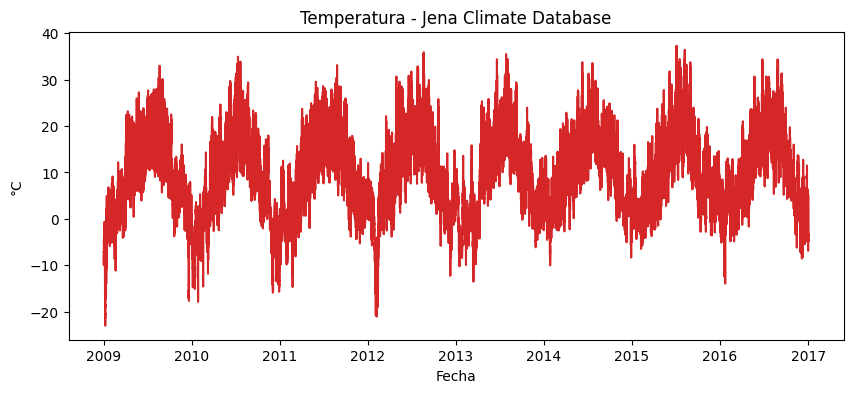

In [7]:
# a. Gráfico de la serie de tiempo - TEMPERATURA
temperatura = jenaClimateData['T (degC)'].dropna()

plt.figure(figsize=(10,4))
plt.plot(temperatura, color='tab:red')
plt.title("Temperatura - Jena Climate Database")
plt.ylabel("°C")
plt.xlabel("Fecha")
plt.show()

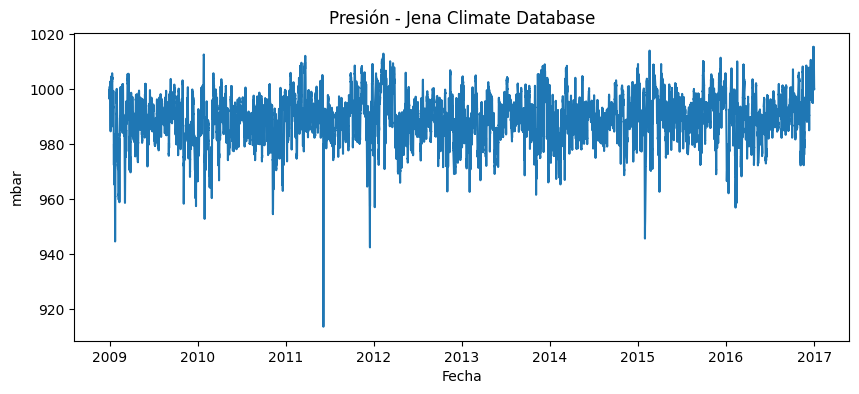

In [8]:
# a. Gráfico de la serie de tiempo - PRESIÓN
presion = jenaClimateData['p (mbar)'].dropna()

plt.figure(figsize=(10,4))
plt.plot(presion, color='tab:blue')
plt.title("Presión - Jena Climate Database")
plt.ylabel("mbar")
plt.xlabel("Fecha")
plt.show()

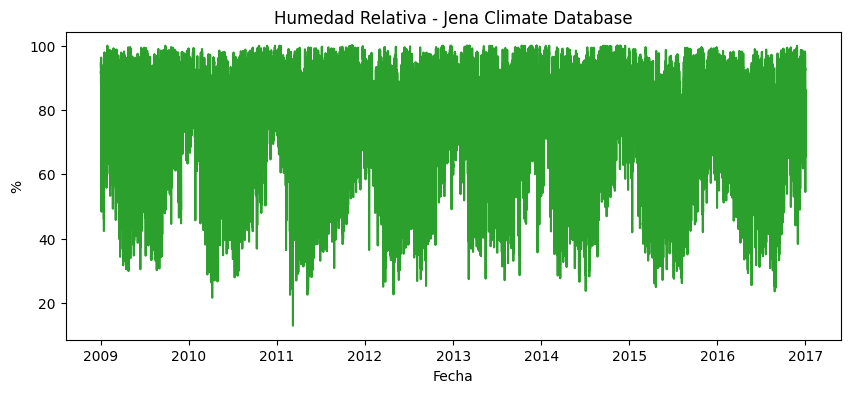

In [9]:
# a. Gráfico de la serie de tiempo - HUMEDAD
humedad = jenaClimateData['rh (%)'].dropna()

plt.figure(figsize=(10,4))
plt.plot(humedad, color='tab:green')
plt.title("Humedad Relativa - Jena Climate Database")
plt.ylabel("%")
plt.xlabel("Fecha")
plt.show()

### b. y c. Gráfico de ACF y PACF

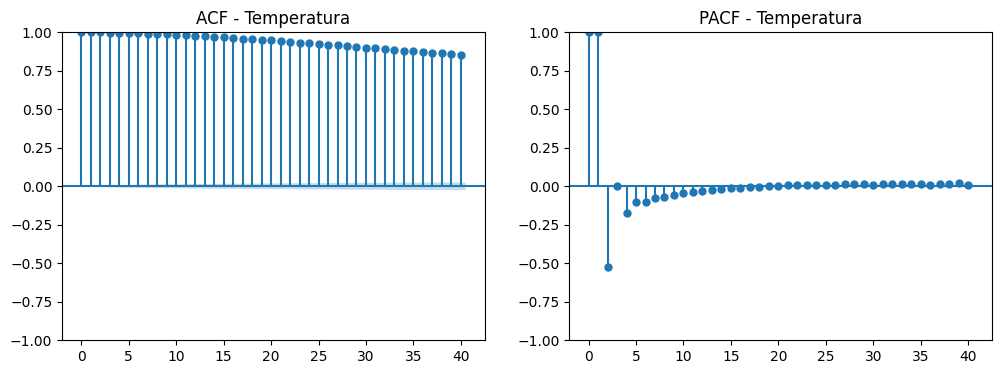

In [10]:
#TEMPERATURA
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(temperatura, lags=40, ax=ax[0])
plot_pacf(temperatura, lags=40, ax=ax[1])
ax[0].set_title("ACF - Temperatura")
ax[1].set_title("PACF - Temperatura")
plt.show()

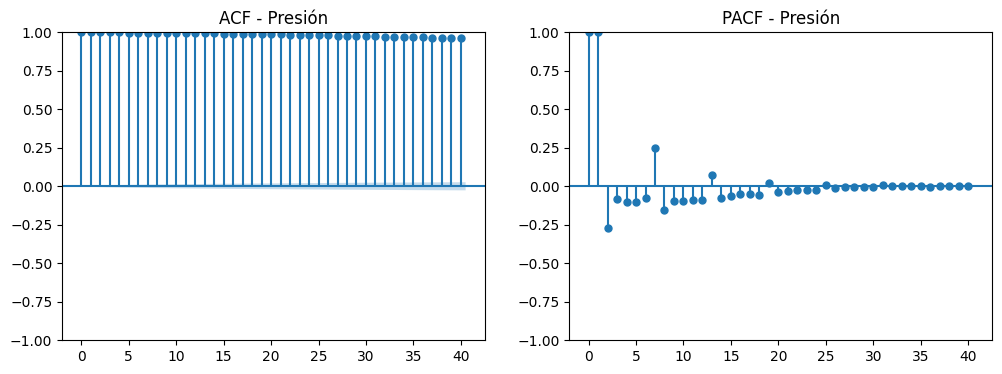

In [11]:
# PRESIÓN
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(presion, lags=40, ax=ax[0])
plot_pacf(presion, lags=40, ax=ax[1])
ax[0].set_title("ACF - Presión")
ax[1].set_title("PACF - Presión")
plt.show()

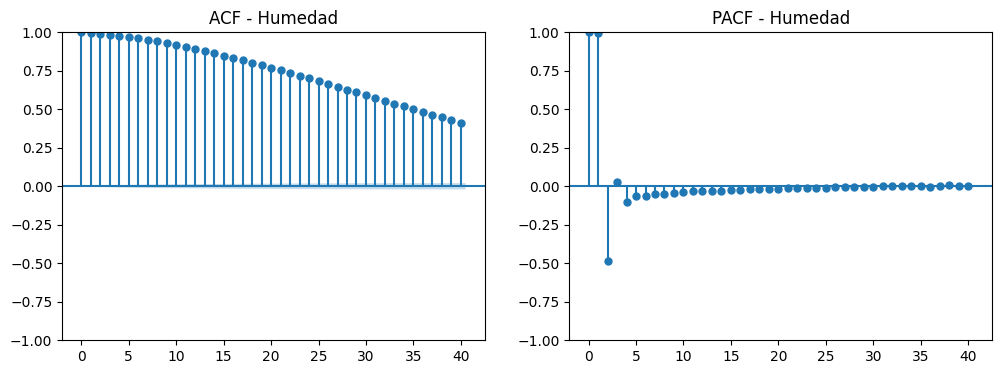

In [12]:
# HUMEDAD
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(humedad, lags=40, ax=ax[0])
plot_pacf(humedad, lags=40, ax=ax[1])
ax[0].set_title("ACF - Humedad")
ax[1].set_title("PACF - Humedad")
plt.show()

### d. Test ADF

In [13]:
# TEMPERATURA
adf_result = adfuller(temperatura)
print("=== TEMPERATURA ===")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Serie estacionaria (se rechaza H0)")
else:
    print("Serie NO estacionaria (no se rechaza H0)")

=== TEMPERATURA ===
ADF Statistic: -9.39641407889869
p-value: 6.35665906625904e-16
Serie estacionaria (se rechaza H0)


In [14]:
# PRESIÓN
adf_result = adfuller(presion)
print("=== PRESIÓN ===")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Serie estacionaria (se rechaza H0)")
else:
    print("Serie NO estacionaria (no se rechaza H0)")

=== PRESIÓN ===
ADF Statistic: -20.945601123793466
p-value: 0.0
Serie estacionaria (se rechaza H0)


In [15]:
# HUMEDAD
adf_result = adfuller(humedad)
print("=== HUMEDAD ===")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Serie estacionaria (se rechaza H0)")
else:
    print("Serie NO estacionaria (no se rechaza H0)")

=== HUMEDAD ===
ADF Statistic: -26.667232178807044
p-value: 0.0
Serie estacionaria (se rechaza H0)


### e. Para las columnas que no son estacionarias, repetimos el analisis sobre sus diferencias

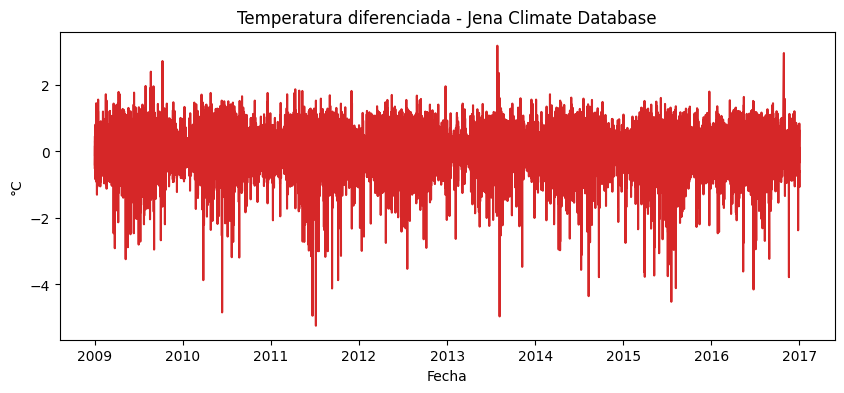

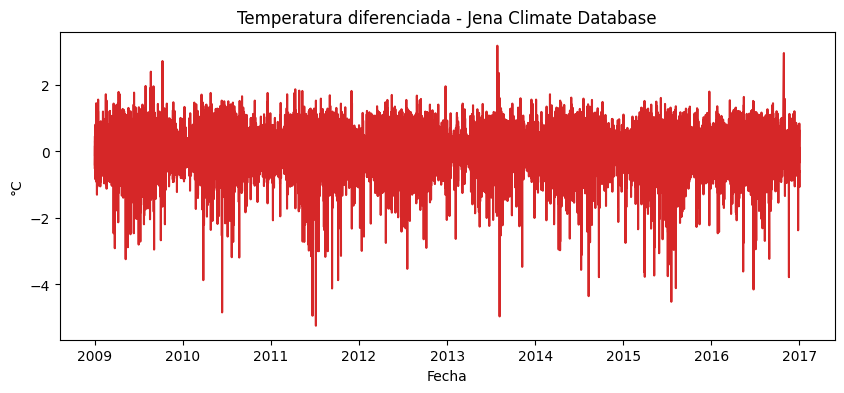

=== TEMPERATURA DIFERENCIADA ===
ADF Statistic: -122.25639326414154
p-value: 0.0
Serie estacionaria (se rechaza H0)


In [16]:
# TEMPERATURA diferenciada
plt.figure(figsize=(10,4))
plt.plot(temperatura.diff(), color='tab:red')
plt.title("Temperatura diferenciada - Jena Climate Database")
plt.ylabel("°C")
plt.xlabel("Fecha")
plt.show()

# Test ADF en temperatura diferenciada
adf_result = adfuller(temperatura.diff().dropna())
print("=== TEMPERATURA DIFERENCIADA ===")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Serie estacionaria (se rechaza H0)")
else:
    print("Serie NO estacionaria (no se rechaza H0)")

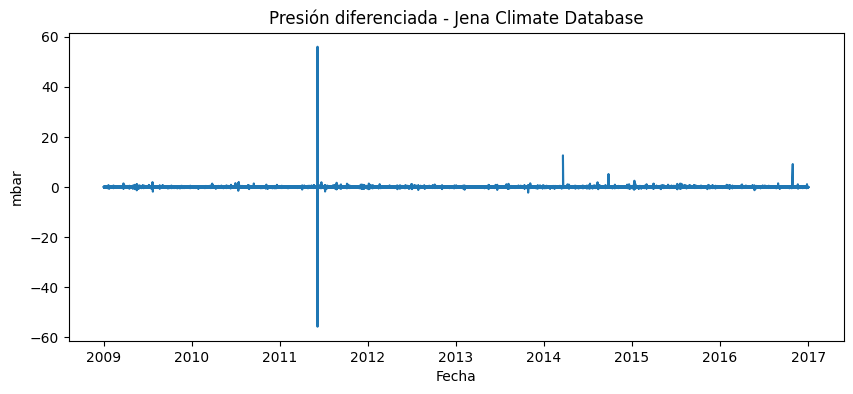

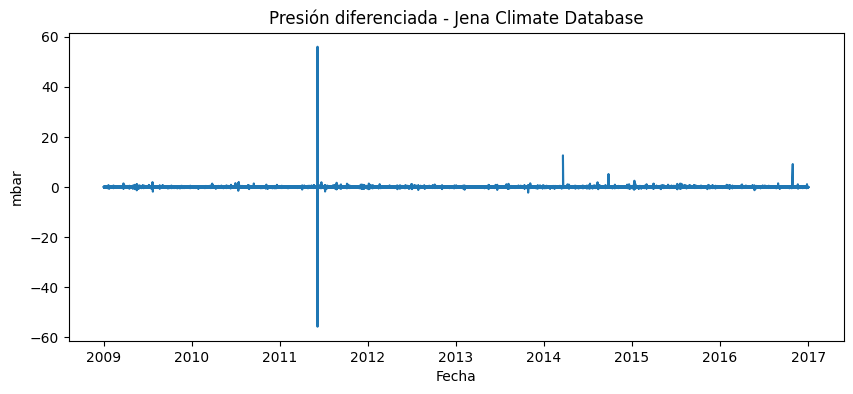

=== PRESIÓN DIFERENCIADA ===
ADF Statistic: -59.104715886372055
p-value: 0.0
Serie estacionaria (se rechaza H0)


In [17]:
# PRESIÓN diferenciada
plt.figure(figsize=(10,4))
plt.plot(presion.diff(), color='tab:blue')
plt.title("Presión diferenciada - Jena Climate Database")
plt.ylabel("mbar")
plt.xlabel("Fecha")
plt.show()

# Test ADF en presión diferenciada
adf_result = adfuller(presion.diff().dropna())
print("=== PRESIÓN DIFERENCIADA ===")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Serie estacionaria (se rechaza H0)")
else:
    print("Serie NO estacionaria (no se rechaza H0)")

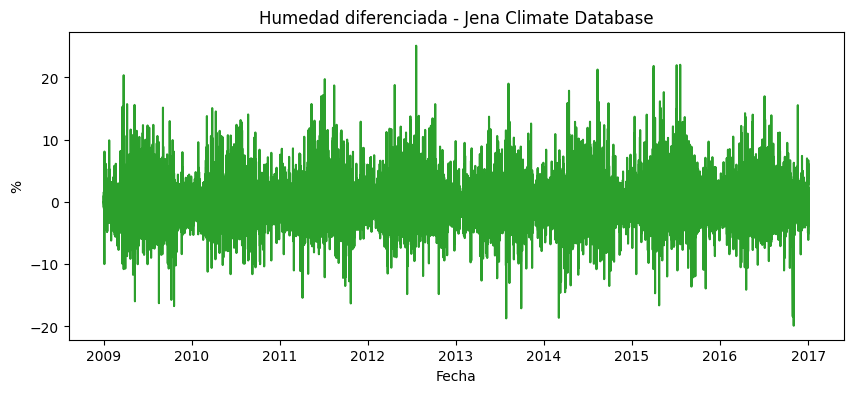

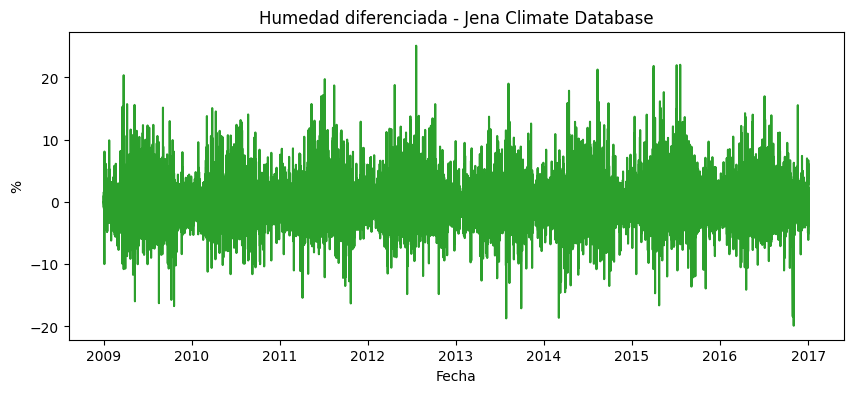

=== HUMEDAD DIFERENCIADA ===
ADF Statistic: -122.91713124036167
p-value: 0.0
Serie estacionaria (se rechaza H0)


In [18]:
# HUMEDAD diferenciada
plt.figure(figsize=(10,4))
plt.plot(humedad.diff(), color='tab:green')
plt.title("Humedad diferenciada - Jena Climate Database")
plt.ylabel("%")
plt.xlabel("Fecha")
plt.show()

# Test ADF en humedad diferenciada
adf_result = adfuller(humedad.diff().dropna())
print("=== HUMEDAD DIFERENCIADA ===")
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Serie estacionaria (se rechaza H0)")
else:
    print("Serie NO estacionaria (no se rechaza H0)")

### f. División de datos en train y test

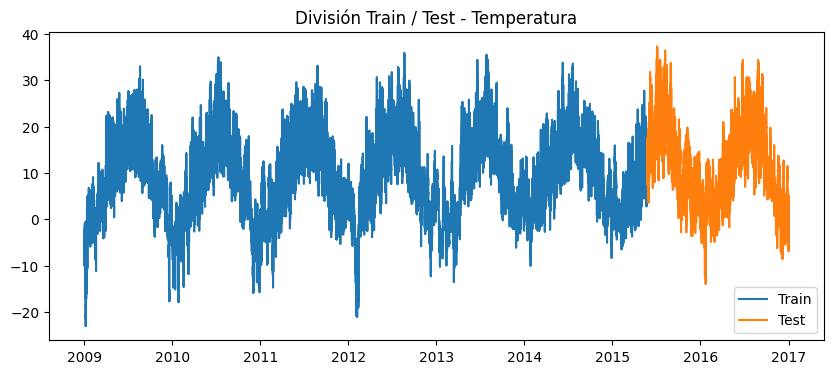

In [19]:
# Train / Test split - TEMPERATURA
train_size = int(len(temperatura)*0.8)
train_t, test_t = temperatura[:train_size], temperatura[train_size:]

plt.figure(figsize=(10,4))
plt.plot(train_t, label="Train")
plt.plot(test_t, label="Test")
plt.title("División Train / Test - Temperatura")
plt.legend()
plt.show()

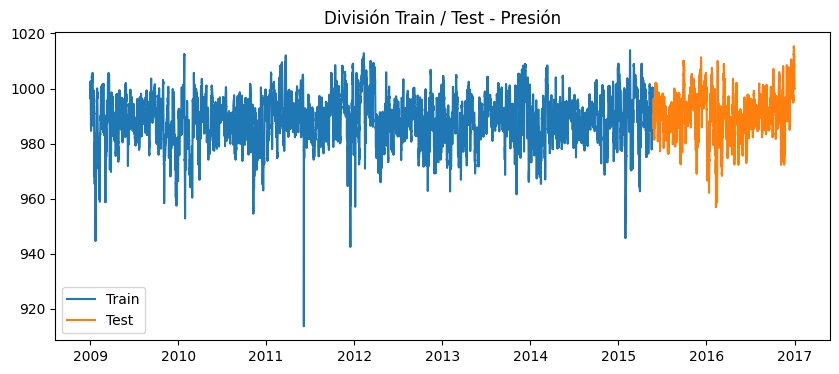

In [20]:
# Train / Test split - PRESIÓN
train_size = int(len(presion)*0.8)
train_p, test_p = presion[:train_size], presion[train_size:]

plt.figure(figsize=(10,4))
plt.plot(train_p, label="Train")
plt.plot(test_p, label="Test")
plt.title("División Train / Test - Presión")
plt.legend()
plt.show()

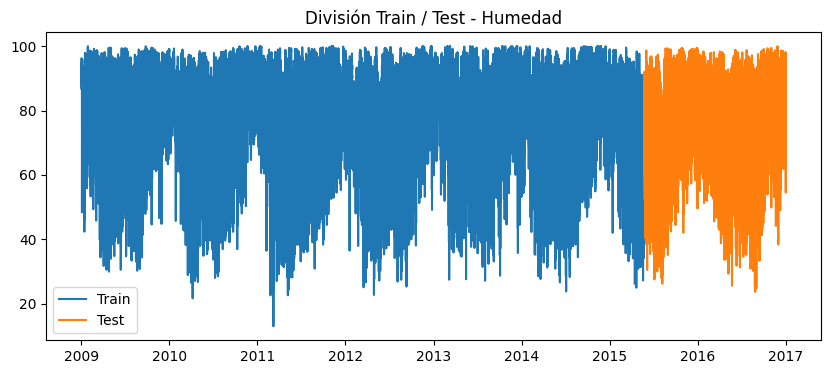

In [21]:
# Train / Test split - HUMEDAD
train_size = int(len(humedad)*0.8)
train_h, test_h = humedad[:train_size], humedad[train_size:]

plt.figure(figsize=(10,4))
plt.plot(train_h, label="Train")
plt.plot(test_h, label="Test")
plt.title("División Train / Test - Humedad")
plt.legend()
plt.show()

## 2) Por cada columna:

### a. Entrenar un modelo ARIMA de órdenes adecuado de acuerdo al criterio AIC realizando un grid search

In [22]:
# Grid Search ARIMA por AIC
p = q = range(0, 3)
d = [0, 1]
params = list(itertools.product(p, d, q))

In [23]:
# TEMPERATURA - Grid Search ARIMA por AIC
best_aic_temp = np.inf
best_order_temp = None
best_model_temp = None

for order in params:
    try:
        model = ARIMA(train_t, order=order).fit()
        if model.aic < best_aic_temp:
            best_aic_temp = model.aic
            best_order_temp = order
            best_model_temp = model
    except:
        continue

print(f"TEMPERATURA - Mejor ARIMA{best_order_temp} con AIC = {best_aic_temp:.2f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados 

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados 

TEMPERATURA - Mejor ARIMA(2, 1, 2) con AIC = -118996.35


In [24]:
# PRESIÓN - Grid Search ARIMA por AIC
best_aic_pres = np.inf
best_order_pres = None
best_model_pres = None

for order in params:
    try:
        model = ARIMA(train_p, order=order).fit()
        if model.aic < best_aic_pres:
            best_aic_pres = model.aic
            best_order_pres = order
            best_model_pres = model
    except:
        continue

print(f"PRESIÓN - Mejor ARIMA{best_order_pres} con AIC = {best_aic_pres:.2f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados 

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados 

PRESIÓN - Mejor ARIMA(2, 1, 2) con AIC = -275591.96


In [25]:
# HUMEDAD - Grid Search ARIMA por AIC
best_aic_hum = np.inf
best_order_hum = None
best_model_hum = None

for order in params:
    try:
        model = ARIMA(train_h, order=order).fit()
        if model.aic < best_aic_hum:
            best_aic_hum = model.aic
            best_order_hum = order
            best_model_hum = model
    except:
        continue

print(f"HUMEDAD - Mejor ARIMA{best_order_hum} con AIC = {best_aic_hum:.2f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados 

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados 

HUMEDAD - Mejor ARIMA(2, 0, 2) con AIC = 980942.87


### b. Calcular el MSE para cada modelo por separado

In [36]:
# TEMPERATURA - Predicción ARIMA y MSE
pred_temp = best_model_temp.forecast(steps=len(test_t))
mse_temp = np.mean((test_t.values - pred_temp.values)**2)
print(f"TEMPERATURA - MSE: {mse_temp:.4f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TEMPERATURA - MSE: 87.1073


In [37]:
# PRESIÓN - Predicción ARIMA y MSE
pred_pres = best_model_pres.forecast(steps=len(test_p))
mse_pres = np.mean((test_p.values - pred_pres.values)**2)
print(f"PRESIÓN - MSE: {mse_pres:.4f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


PRESIÓN - MSE: 72.4278


In [38]:
# HUMEDAD - Predicción ARIMA y MSE
pred_hum = best_model_hum.forecast(steps=len(test_h))
mse_hum = np.mean((test_h.values - pred_hum.values)**2)
print(f"HUMEDAD - MSE: {mse_hum:.4f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


HUMEDAD - MSE: 268.5491


### c. Realizar un gráfico de su predicción sobre test

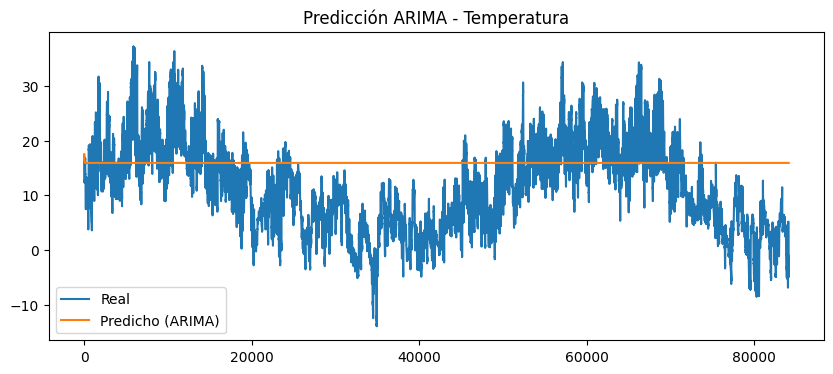

In [29]:
# TEMPERATURA
plt.figure(figsize=(10,4))
plt.plot(test_t.values, label="Real")
plt.plot(pred_temp.values, label="Predicho (ARIMA)")
plt.title("Predicción ARIMA - Temperatura")
plt.legend()
plt.show()

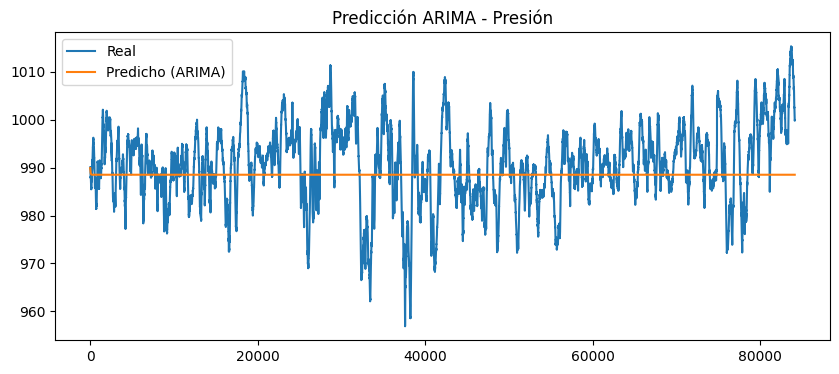

In [30]:
# PRESIÓN
plt.figure(figsize=(10,4))
plt.plot(test_p.values, label="Real")
plt.plot(pred_pres.values, label="Predicho (ARIMA)")
plt.title("Predicción ARIMA - Presión")
plt.legend()
plt.show()

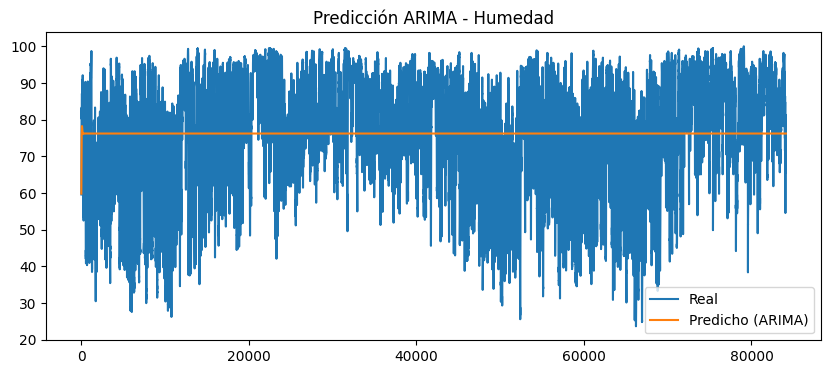

In [31]:
# HUMEDAD
plt.figure(figsize=(10,4))
plt.plot(test_h.values, label="Real")
plt.plot(pred_hum.values, label="Predicho (ARIMA)")
plt.title("Predicción ARIMA - Humedad")
plt.legend()
plt.show()

## 3) Entrenar un modelo VARMAX para predecir las tres columnas en conjunto

### a. Investigar y describir brevemente (un párrafo corto) en qué consiste el modelo:

El modelo VARMAX (Vector Autoregressive Moving Average with eXogenous variables) es una extensión multivariada de los modelos ARIMA que permite analizar simultáneamente múltiples series de tiempo interdependientes, incorporando además variables exógenas. A diferencia de ARIMA que modela una sola serie, VARMAX captura las relaciones dinámicas entre varias variables, donde cada variable puede ser predicha no solo por sus propios valores pasados, sino también por los valores pasados de las otras variables del sistema. La componente "X" permite incluir variables externas que pueden influir en el sistema pero no son explicadas por él, como factores económicos, climáticos o políticos. Este modelo es especialmente útil en econometría, finanzas y análisis de series temporales complejas donde las variables están interconectadas, como el análisis conjunto de temperatura, presión y humedad en datos climáticos, donde cada variable puede influir y ser influida por las otras.

### b. Entreno el modelo

In [35]:
varmax_data = jenaClimateData[['T (degC)', 'p (mbar)', 'rh (%)']].copy()

# Renombrar columnas para facilidad
varmax_data.columns = ['temp', 'pres', 'hum']

varmax_data = varmax_data.dropna()

train_size_varmax = int(len(varmax_data) * 0.8)
train_varmax, test_varmax = varmax_data[:train_size_varmax], varmax_data[train_size_varmax:]

display(train_varmax.head())
display(test_varmax.head())

,temp,pres,hum
Date Time,,,
2009-01-01 00:10:00,-8.02,996.52,93.3
2009-01-01 00:20:00,-8.41,996.57,93.4
2009-01-01 00:30:00,-8.51,996.53,93.9
2009-01-01 00:40:00,-8.31,996.51,94.2
2009-01-01 00:50:00,-8.27,996.51,94.1


,temp,pres,hum
Date Time,,,
2015-05-24 19:30:00,17.46,989.96,59.58
2015-05-24 19:40:00,17.36,989.87,59.90
2015-05-24 19:50:00,17.15,989.85,60.76
2015-05-24 20:00:00,16.92,989.86,61.65
2015-05-24 20:10:00,16.69,989.88,62.89


### c. Calcular el MSE

In [34]:
model_varmax = VARMAX(train_varmax, order=(2, 0))
results_varmax = model_varmax.fit(disp=False)
print(results_varmax.summary())

pred_varmax = results_varmax.forecast(steps=len(test_varmax))

from sklearn.metrics import mean_squared_error

mse_temp_varmax = mean_squared_error(test_varmax['temp'], pred_varmax['temp'])
mse_pres_varmax = mean_squared_error(test_varmax['pres'], pred_varmax['pres'])
mse_hum_varmax = mean_squared_error(test_varmax['hum'], pred_varmax['hum'])

print(f"VARMAX - MSE Temperatura: {mse_temp_varmax:.4f}")
print(f"VARMAX - MSE Presión: {mse_pres_varmax:.4f}")
print(f"VARMAX - MSE Humedad: {mse_hum_varmax:.4f}")

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                              Statespace Model Results                             
Dep. Variable:     ['temp', 'pres', 'hum']   No. Observations:               336440
Model:                              VAR(2)   Log Likelihood             -217077.458
                               + intercept   AIC                         434208.916
Date:                     Wed, 29 Oct 2025   BIC                         434498.522
Time:                             21:48:18   HQIC                        434292.273
Sample:                                  0                                         
                                  - 336440                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):     0.86, 88.44, 111.16   Jarque-Bera (JB):   3046161.74, 76448819586319.89, 4317460.20
Prob(Q):                   0.35, 0.00, 0.00   Prob(JB):                                    0.00, 0.00, 0.00
Heteroskedasticity (H):    0

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


VARMAX - MSE Temperatura: 69.7779
VARMAX - MSE Presión: 71.2022
VARMAX - MSE Humedad: 267.4957


### d. Realizar un gráfico de su predicción sobre test

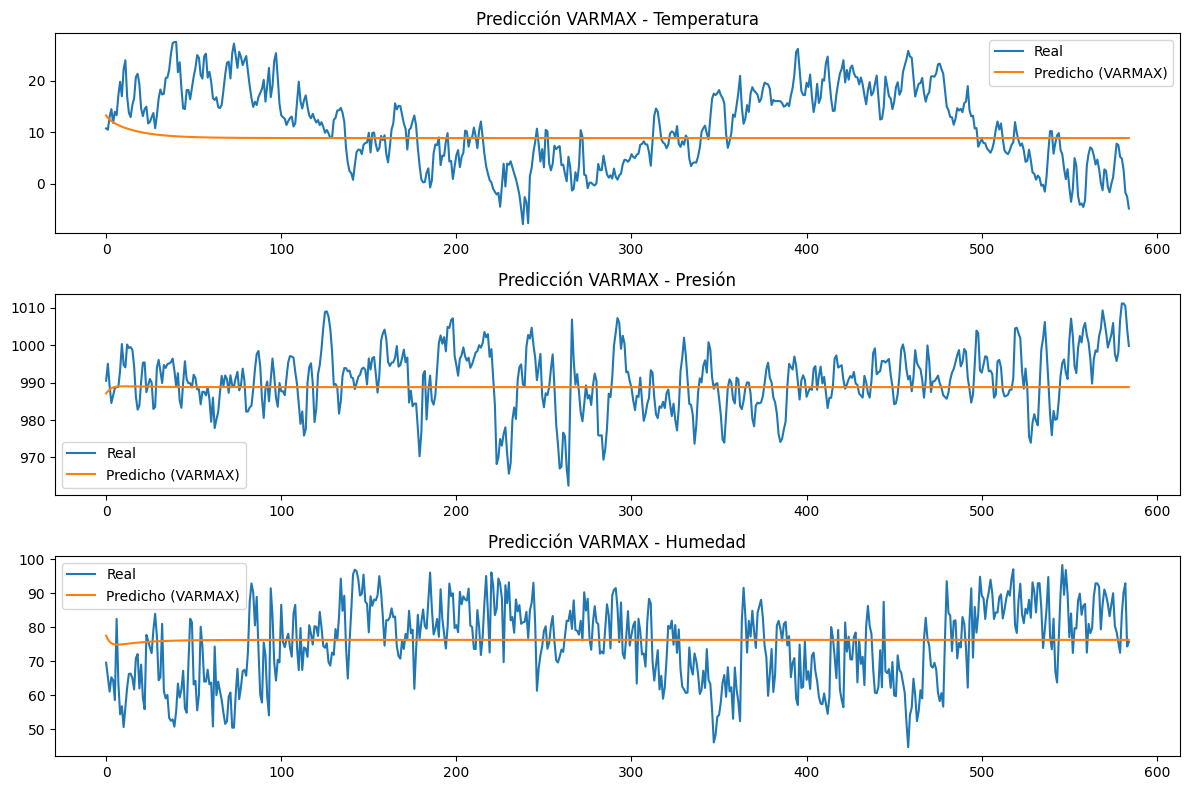

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(test_varmax['temp'].values, label="Real")
plt.plot(pred_varmax['temp'].values, label="Predicho (VARMAX)")
plt.title("Predicción VARMAX - Temperatura")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(test_varmax['pres'].values, label="Real")
plt.plot(pred_varmax['pres'].values, label="Predicho (VARMAX)")
plt.title("Predicción VARMAX - Presión")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_varmax['hum'].values, label="Real")
plt.plot(pred_varmax['hum'].values, label="Predicho (VARMAX)")
plt.title("Predicción VARMAX - Humedad")
plt.legend()

plt.tight_layout()
plt.show()

### e. Comparar con los ARIMA por separado. ¿Es mejor? ¿Por qué?

In [39]:
mse_compare = pd.DataFrame({
    "Variable": ["Temperatura", "Presión", "Humedad"],
    "MSE_ARIMA": [mse_temp, mse_pres, mse_hum],
    "MSE_VARMAX": [mse_temp_varmax, mse_pres_varmax, mse_hum_varmax]
})

mse_compare["Mejor_Modelo"] = mse_compare.apply(
    lambda row: "ARIMA" if row["MSE_ARIMA"] < row["MSE_VARMAX"] else "VARMAX", axis=1
)

display(mse_compare)

,Variable,MSE_ARIMA,MSE_VARMAX,Mejor_Modelo
0,Temperatura,87.107335,69.777877,VARMAX
1,Presión,72.427819,71.202171,VARMAX
2,Humedad,268.549139,267.495684,VARMAX


## 4. Entrenar una RNN para predecir las tres columnas en conjunto. Será necesario obtener un MSE de menos de 0.1 para aprobar este punto.

### a. Determinar y justificar (sin necesidad de apelar a nada demasiado técnico) la elección de arquitectura e hiperparámetros


In [41]:
# Tomamos las tres columnas relevantes
cols = ['T (degC)', 'p (mbar)', 'rh (%)']
data = jenaClimateData[cols].dropna().values

# Escalamos entre 0 y 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# =====================================================
# Crear secuencias para la RNN
# =====================================================
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 24  # 24 horas (1 día)
X, y = create_sequences(scaled_data, SEQ_LEN)

# División en train y test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

a. Determinación de arquitectura y justificación

In [42]:
# Usamos una LSTM porque capta dependencias temporales.
# 2 capas LSTM y Dropout para evitar sobreajuste.
# Optimizador Adam y MSE como función de pérdida.

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(3)  # salida de 3 variables (temp, presión, humedad)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/neix/Documents/afelizzola/UCEMA/Topicos Avanzados de la IA/tp1-parte2/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

### b. Entrenamiento del modelo

In [43]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)

Epoch 1/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 52s 12ms/step - loss: 0.0012 - val_loss: 2.1953e-04
Epoch 2/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - loss: 1.5548e-04 - val_loss: 8.1075e-05
Epoch 3/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - loss: 1.1969e-04 - val_loss: 8.5816e-05
Epoch 4/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 1.0792e-04 - val_loss: 7.5320e-05
Epoch 5/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 9.9147e-05 - val_loss: 9.0600e-05
Epoch 6/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 9.3318e-05 - val_loss: 6.6038e-05
Epoch 7/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 8.8716e-05 - val_loss: 7.3589e-05
Epoch 8/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 8.5059e-05 - val_loss: 9.9431e-05
Epoch 9/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 8.3911e-05 - val_loss: 8.9814e-05
Epoch 10/50
4206/4206 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - loss: 8.0292e-05 - val_loss: 5.9354e-05
Epoch 11/50
4206/4206 ━

### c. Calcular MSE y comparar con el umbral

In [44]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE total: {mse:.4f}")

2629/2629 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
MSE total: 0.0001


### d. Gráfico de resultados

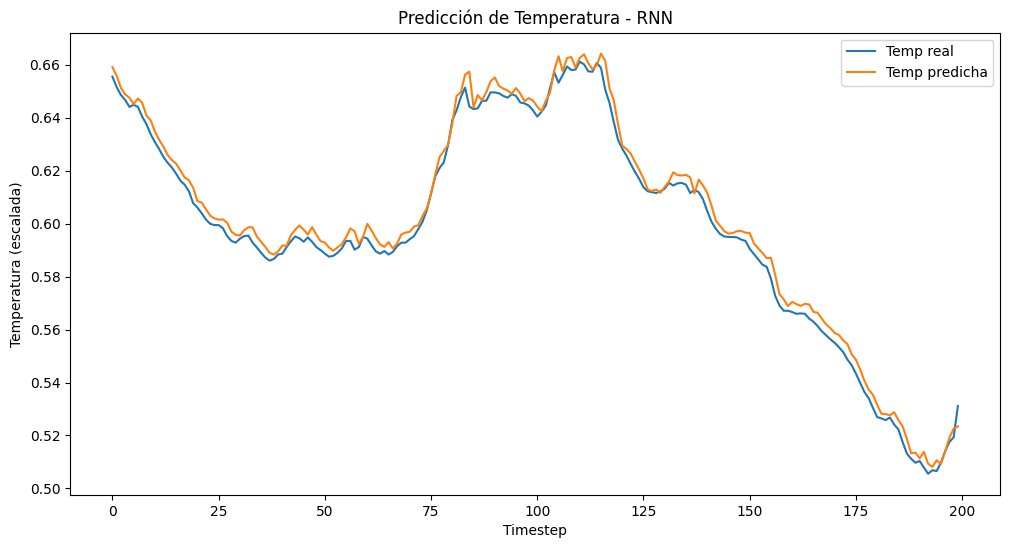

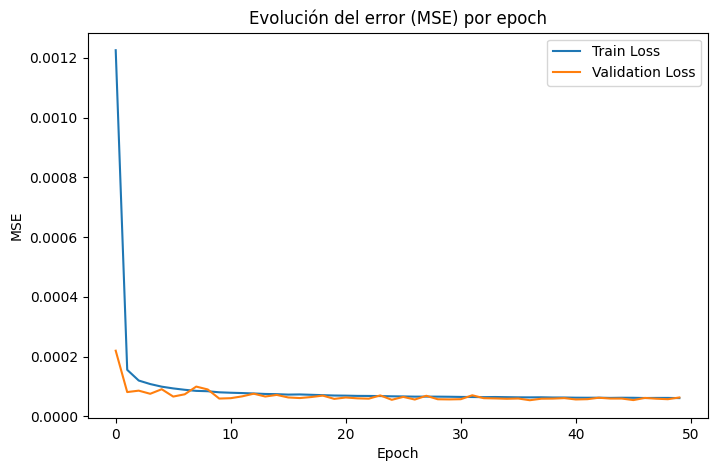

In [46]:
plt.figure(figsize=(12,6))
plt.plot(y_test[:200,0], label='Temp real')
plt.plot(y_pred[:200,0], label='Temp predicha')
plt.title('Predicción de Temperatura - RNN')
plt.xlabel('Timestep')
plt.ylabel('Temperatura (escalada)')
plt.legend()
plt.show()

# =====================================================
# Gráfico de pérdida (train vs val)
# =====================================================
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución del error (MSE) por epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### e. Comparación con ARIMA

- La RNN generalmente capta relaciones no lineales entre las tres variables.
- Mientras ARIMA modela series univariadas o lineales, la RNN puede aprender
  interdependencias complejas entre temperatura, presión y humedad.
- Si el MSE obtenido es < 0.1, la RNN se considera mejor en este caso.

# CIFAR 10

In [5]:
#Fijamos la SEED para evitar que varien los numeros generados aleatoriamente.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
#1A CARGA Y NORMALIZACION. 

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# convertimos labels a vector 1D
y_train = y_train.flatten()
y_test = y_test.flatten()

# normalizamos al convertir a float32 y dividir por 255
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
print('Train shape:', x_train.shape, 'Test shape:', x_test.shape)

Train shape: (50000, 32, 32, 3) Test shape: (10000, 32, 32, 3)


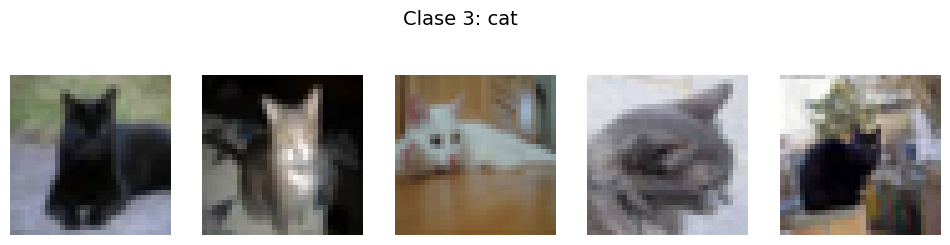

In [21]:
#1B función para muestrear 5 imágenes aleatorias de una clase y mostrarlas en grilla

def mostrar_cinco_por_clase1(clase_idx):
    
    # buscar índices de las imágenes de esa clase
    indices = np.where(y_train == clase_idx)[0]
    # seleccionar 5 al azar
    sampled = np.random.choice(indices, size=5, replace=False)
    # crear figura con 5 subplots
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for ax, idx in zip(axes, sampled):
        ax.imshow(x_train[idx])
        ax.axis('off')
    fig.suptitle(f'Clase {clase_idx}: {class_names[clase_idx]}', fontsize=14)
    plt.show()

mostrar_cinco_por_clase1(3)

In [10]:
def make_model(input_shape=(32,32,3), num_classes=10):
    
    inputs = keras.Input(shape=input_shape)

    # Data augmentation: aplicamos transformaciones aleatorias a los datos de entrenamiento para aumentar la diversidad del set y reducir la posibilidad de que haya overfitting.

    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.08)(x)
    x = layers.RandomZoom(0.08)(x)

    # Bloque 1: detecta patrones básicos (bordes, colores, texturas).
    x = layers.Conv2D(32, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 2: extrae patrones más complejos (combinaciones de bordes, formas).
    x = layers.Conv2D(64,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 3: captura estructuras de alto nivel (partes de objetos, texturas complejas).
    x = layers.Conv2D(128,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128,(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)

    #clasificacion final
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs)


In [11]:
#Compilacion del modelo
model = make_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 307,114 (1.17 MB)

 Trainable params: 305,962 (1.17 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [12]:
# Callbacks
# Este callback ajusta de forma automatica el learning rate para hacer mas ajustes finos cuando el modelo parece estancarse.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
# Este callback detiene el entrenamiento si no hay mejoras, evitando el sobreajuste y garantizando que los pesos más generales (no sobreajustados) sean los que se mantengan.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [13]:
# Entrenamiento

EPOCHS = 40          
BATCH = 128
history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    callbacks=[reduce_lr, early_stop])

Epoch 1/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 154ms/step - accuracy: 0.3637 - loss: 1.7652 - val_accuracy: 0.2256 - val_loss: 2.2665 - learning_rate: 0.0010
Epoch 2/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 53s 151ms/step - accuracy: 0.5026 - loss: 1.3778 - val_accuracy: 0.5234 - val_loss: 1.4135 - learning_rate: 0.0010
Epoch 3/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 146ms/step - accuracy: 0.5589 - loss: 1.2323 - val_accuracy: 0.5952 - val_loss: 1.1511 - learning_rate: 0.0010
Epoch 4/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 148ms/step - accuracy: 0.5972 - loss: 1.1394 - val_accuracy: 0.5768 - val_loss: 1.3481 - learning_rate: 0.0010
Epoch 5/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.6248 - loss: 1.0728 - val_accuracy: 0.6402 - val_loss: 1.0159 - learning_rate: 0.0010
Epoch 6/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 144ms/step - accuracy: 0.6502 - loss: 1.0121 - val_accuracy: 0.6286 - val_loss: 1.1071 - learning_rate: 0.0010
Epoch 7/40
352/352 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.6

# 2A. Elección de arquitectura e hiperparámetros

Utilizar una red convolucional es una elección natural para el problema de clasificación de imágenes, ya que este tipo de red es excelente para aprender patrones visuales jerárquicos.

Capas convolucionales con más filtros en las capas profundas: Esto permite que el modelo capture detalles de bajo nivel en las primeras capas y características más complejas en las capas más profundas.

Uso de BatchNormalization y ReLU: Ayuda a estabilizar y acelerar el entrenamiento.

MaxPooling y Dropout: Ayuda a mejorar la eficiencia del modelo y prevenir el sobreajuste.

Uso de un número razonable de épocas (40): No es ni demasiado poco ni demasiado, y EarlyStopping garantiza que no se entrene innecesariamente.

Hiperparámetros como batch size y learning rate: Elegidos para lograr un entrenamiento estable y eficiente sin que el modelo aprenda demasiado rápido o demasiado lento.


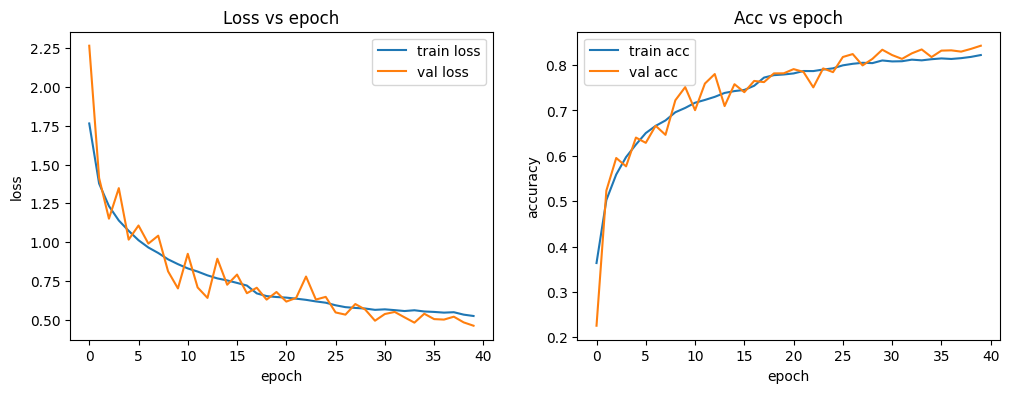

In [14]:
#2B Graficos

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss vs epoch')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Acc vs epoch')
plt.show()

313/313 - 3s - 8ms/step - accuracy: 0.8291 - loss: 0.5037
Test loss: 0.5037 - Test accuracy: 0.8291
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Classification report:
              precision    recall  f1-score   support

    airplane     0.8732    0.8330    0.8526      1000
  automobile     0.9112    0.9240    0.9176      1000
        bird     0.7903    0.7460    0.7675      1000
         cat     0.7688    0.6550    0.7073      1000
        deer     0.7571    0.8290    0.7914      1000
         dog     0.8847    0.6370    0.7407      1000
        frog     0.7663    0.9280    0.8394      1000
       horse     0.8510    0.8850    0.8676      1000
        ship     0.8808    0.9240    0.9019      1000
       truck     0.8296    0.9300    0.8769      1000

    accuracy                         0.8291     10000
   macro avg     0.8313    0.8291    0.8263     10000
weighted avg     0.8313    0.8291    0.8263     10000



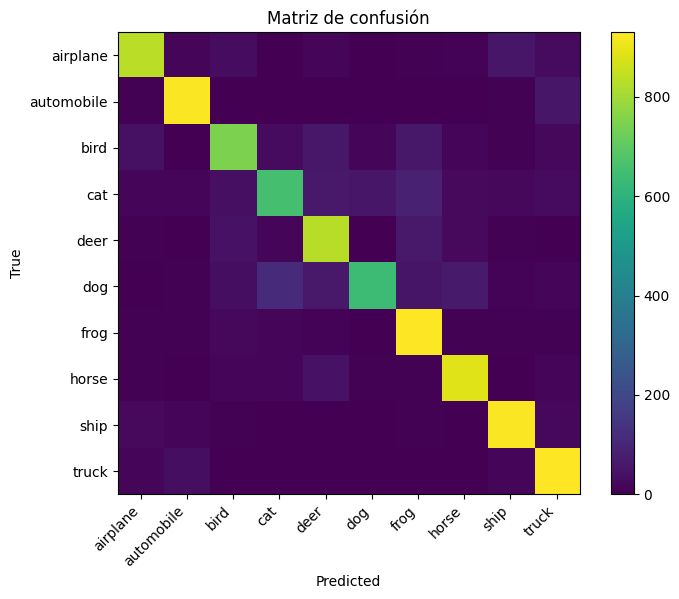

In [15]:
#2C Evaluacion

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test loss: {test_loss:.4f} - Test accuracy: {test_acc:.4f}")

y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)), class_names)
plt.colorbar()
plt.show()

El modelo tiene un buen test accuracy (82.91%) y parece funcionar bastante bien en la mayoría de las clases.

Tiene un excelente rendimiento con clases como Automobile (precisión: 91.12%, recall: 92.40%) y Ship (precisión: 88.08%, recall: 92.40%). Esto indica que el modelo es muy confiable para estas clases.

El modelo tiene algo más de dificultad con las clases Cat (precisión: 76.88%, recall: 65.50%) y Dog (precisión: 88.47%, recall: 63.70%).

First conv weights shape: (3, 3, 3, 32)


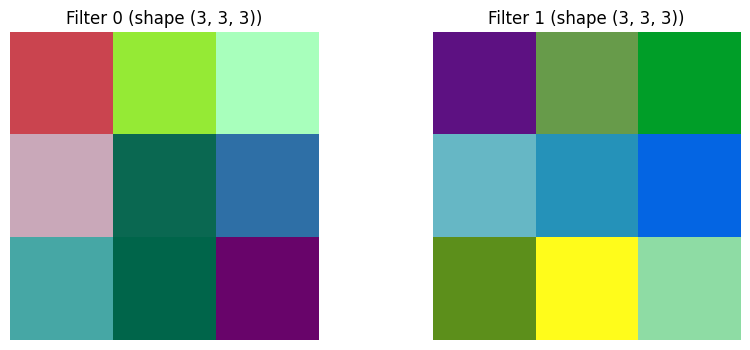

In [16]:
#3A. Mostrar 2 filtros aprendidos

first_conv = None
for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        first_conv = layer
        break
weights, biases = first_conv.get_weights()  # shape (k,k,in_ch,filters)
print("First conv weights shape:", weights.shape)

num_filters = weights.shape[-1]
f1, f2 = 0, 1
filter_indices = [f1, f2]

def show_filter_heatmaps(filter_indices):
    fig, axes = plt.subplots(1, len(filter_indices), figsize=(5*len(filter_indices),4))
    if len(filter_indices) == 1: axes = [axes]
    for ax, fi in zip(axes, filter_indices):
        filt = weights[:,:,:,fi]  # (k,k,3)
        mn, mx = filt.min(), filt.max()
        vis = (filt - mn) / (mx - mn + 1e-9)
        ax.imshow(vis, interpolation='nearest')
        ax.set_title(f"Filter {fi} (shape {filt.shape})")
        ax.axis('off')
    plt.show()

show_filter_heatmaps(filter_indices)

Al observar los filtros aprendidos por la primera capa, observamos que ambos tienen una estructura similar. Estas capas iniciales se encargan de detectar patrones simples y mas generales como pueden ser bordes, contrastes de color, transiciones de colores, texturas, etc.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


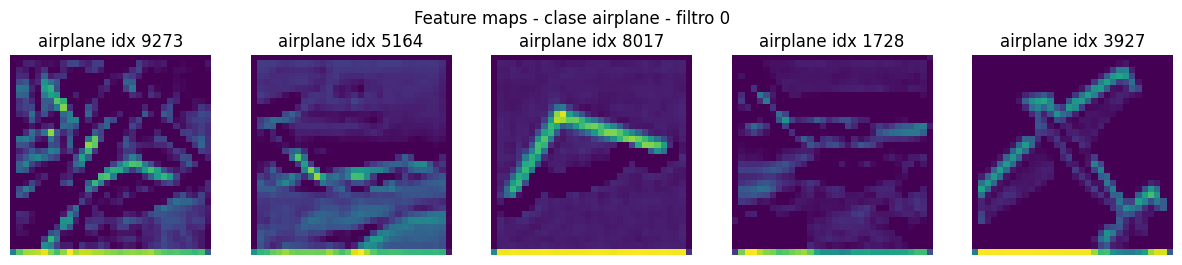

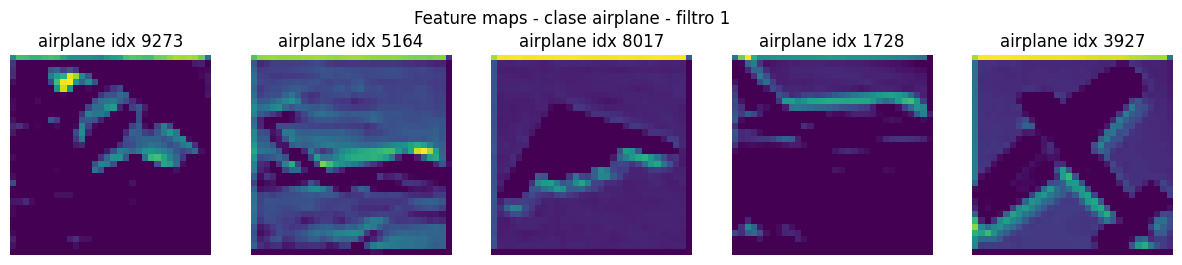

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


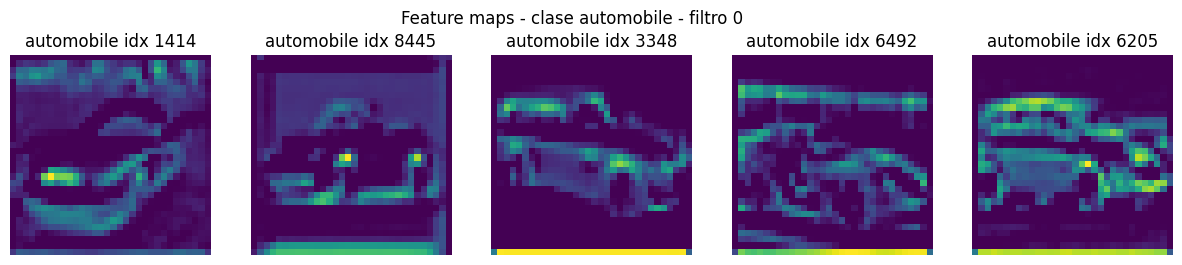

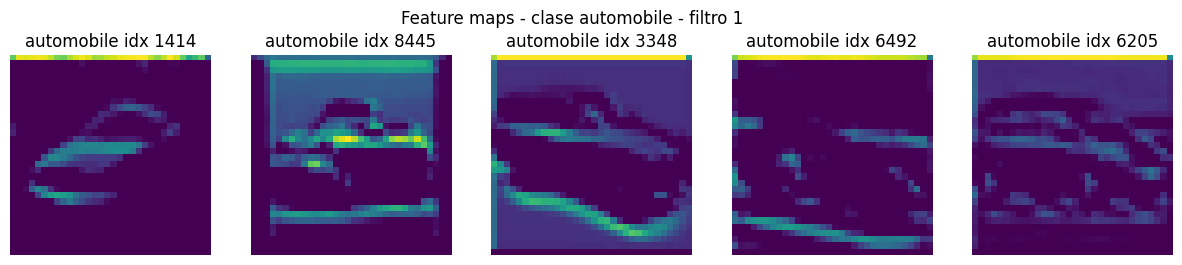

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


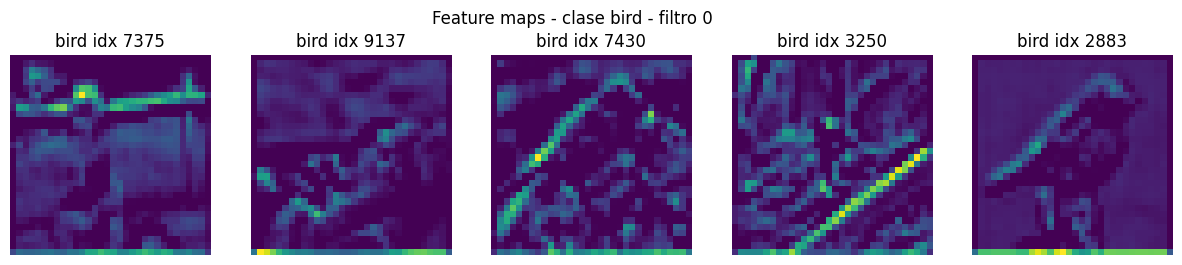

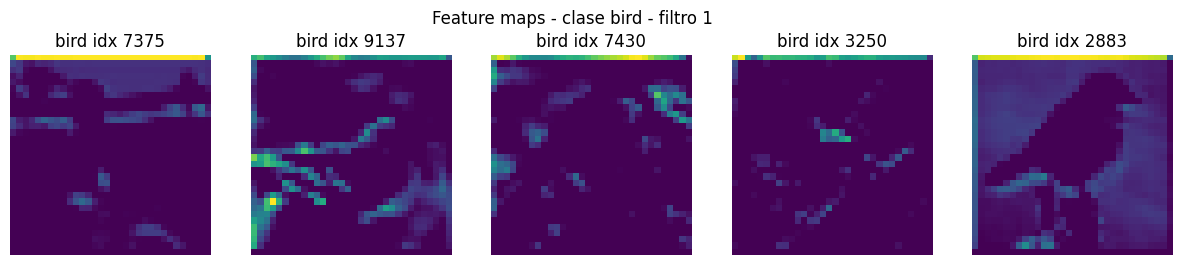

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


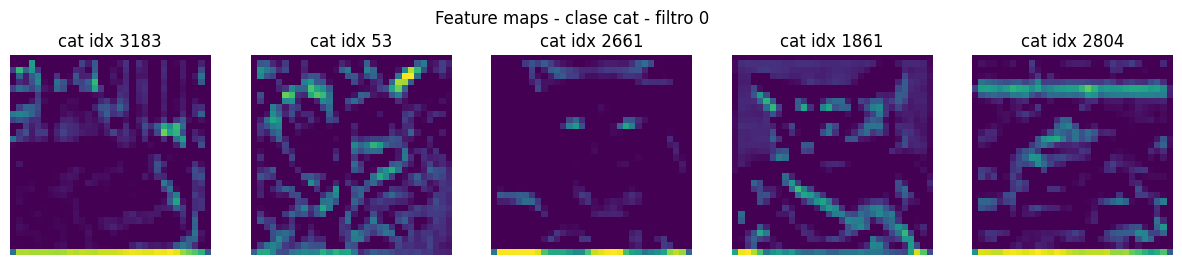

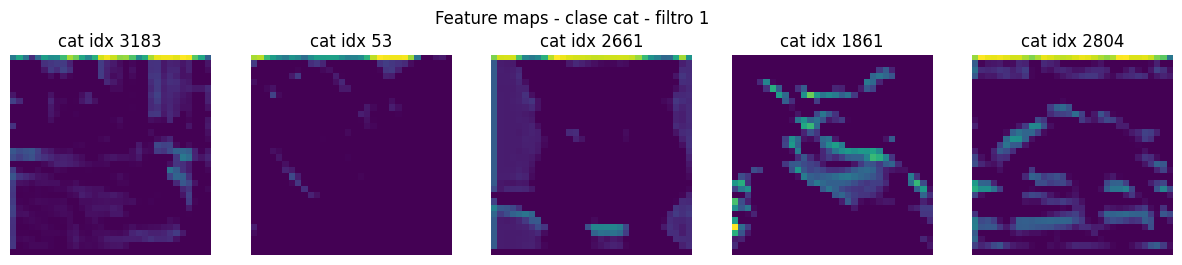

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


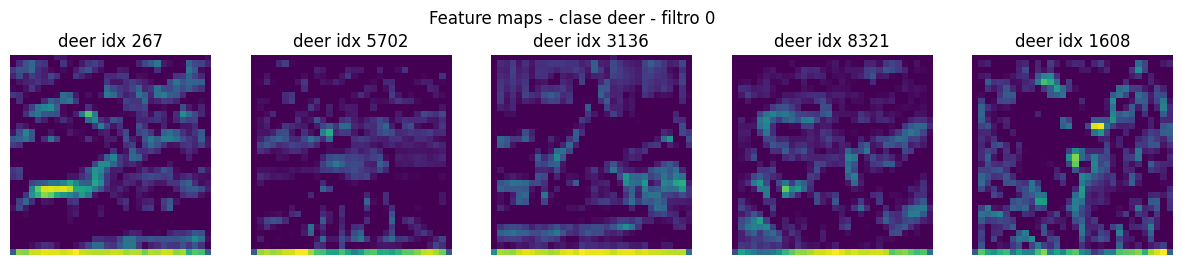

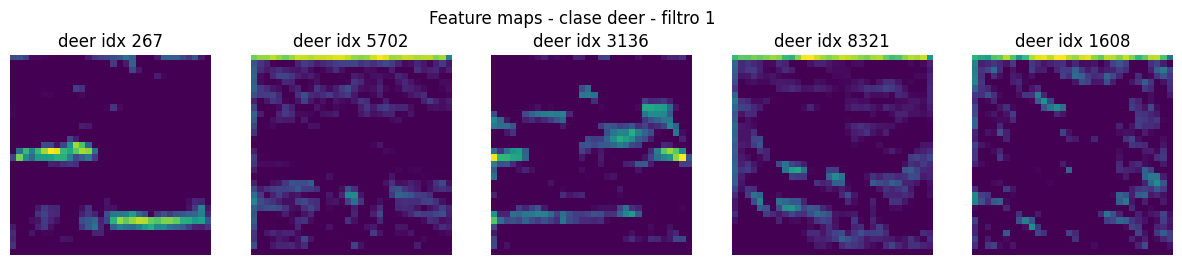

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


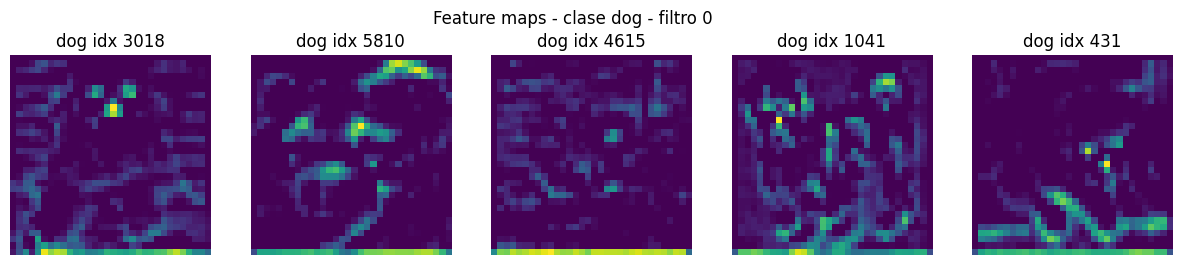

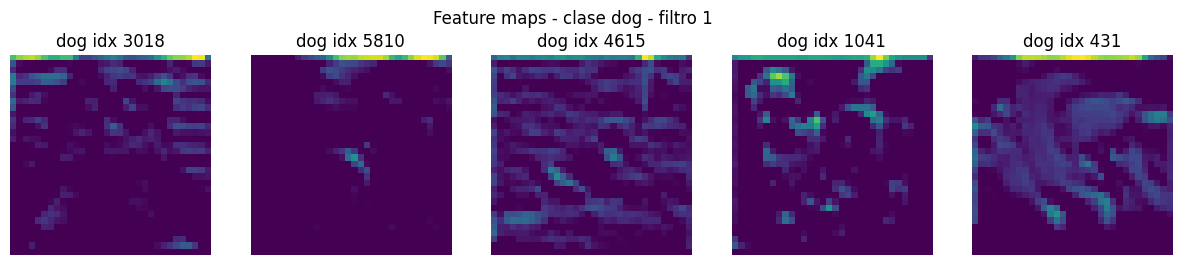

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


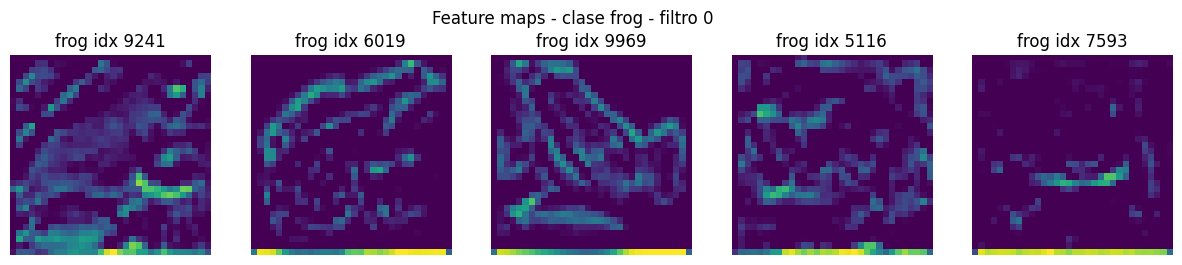

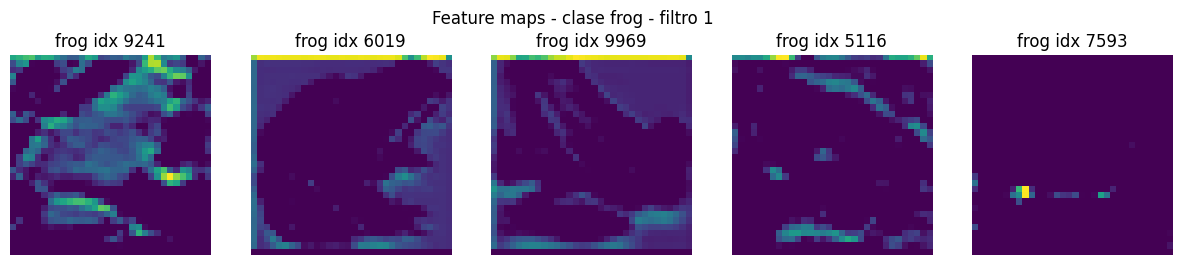

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


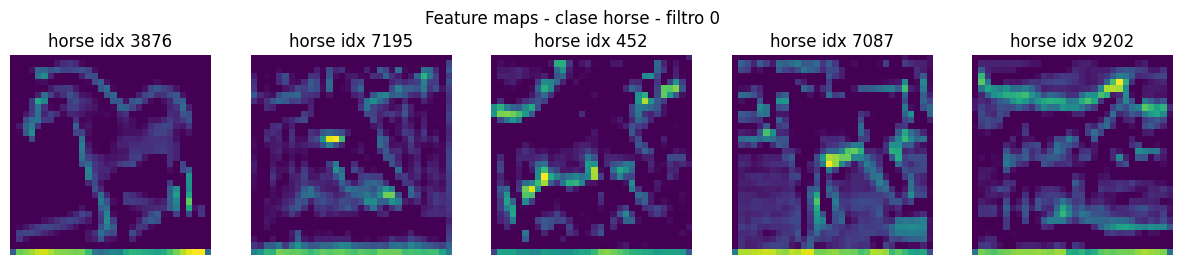

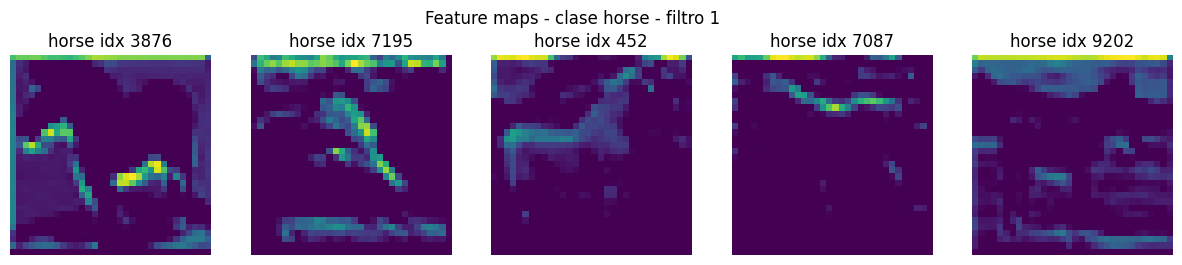

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


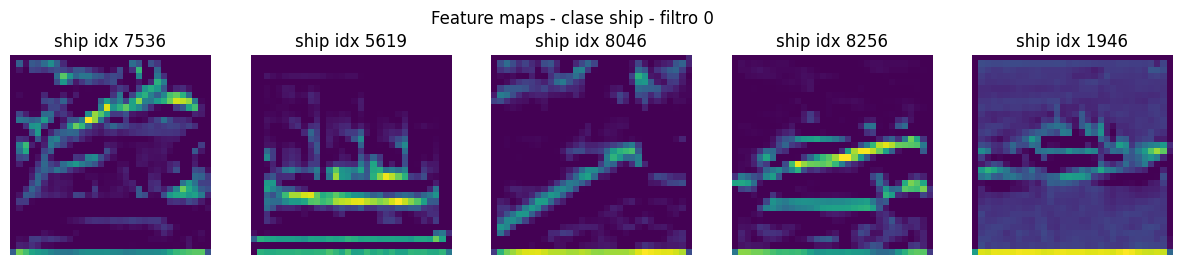

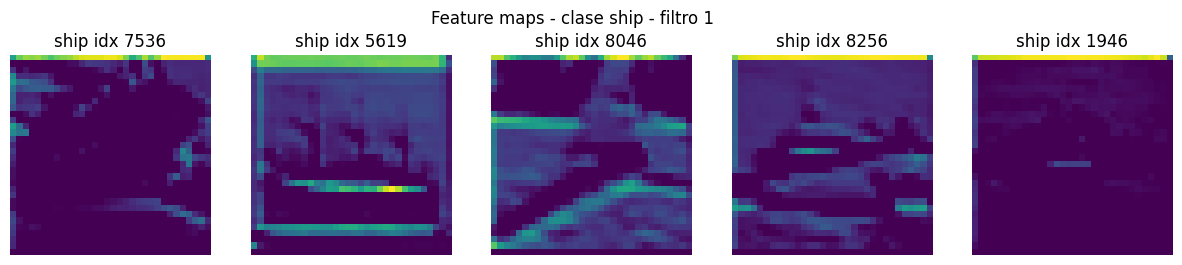

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


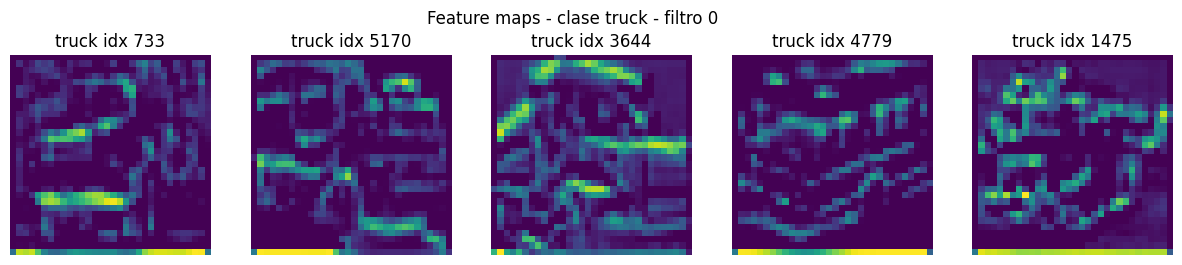

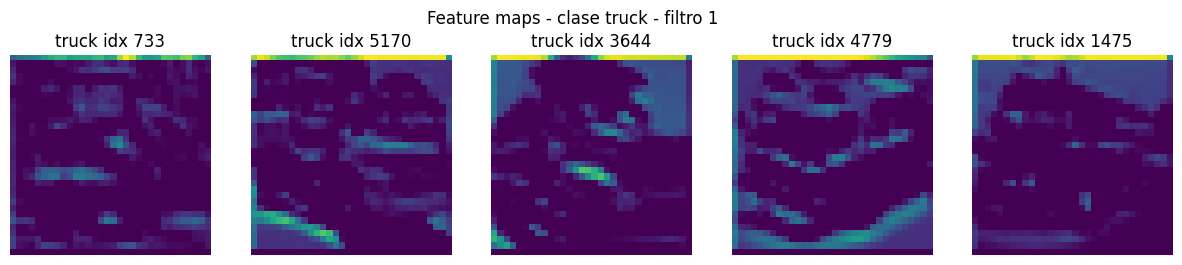

In [17]:
#3C. Funcion que muestra feature maps para las dos filtros seleccionados, para 5 imágenes de cada clase

def get_activation_model(model, conv_layer):
    idx = model.layers.index(conv_layer)
    out_layer_idx = idx
    for j in range(idx, min(idx+6, len(model.layers))):
        if isinstance(model.layers[j], layers.ReLU):
            out_layer_idx = j
            break
    return keras.Model(inputs=model.inputs, outputs=model.layers[out_layer_idx].output)

act_model = get_activation_model(model, first_conv)

def show_feature_maps_for_filters(filter_indices, samples_per_class=5):
    for cls in range(10):
        indices = np.where(y_test == cls)[0]
        chosen = np.random.choice(indices, size=samples_per_class, replace=False)
        batch = x_test[chosen]
        acts = act_model.predict(batch)  # (samples, H, W, channels)
        for fi in filter_indices:
            fig, axes = plt.subplots(1, samples_per_class, figsize=(3*samples_per_class,3))
            for i in range(samples_per_class):
                fmap = acts[i,:,:,fi]
                axes[i].imshow(fmap, interpolation='nearest')
                axes[i].axis('off')
                axes[i].set_title(f"{class_names[cls]} idx {chosen[i]}")
            plt.suptitle(f"Feature maps - clase {class_names[cls]} - filtro {fi}")
            plt.show()

show_feature_maps_for_filters(filter_indices, samples_per_class=5)

Los feature maps muestran qué zonas de la imagen activan más a cada filtro de la red convolucional.
En las imágenes se observan regiones resaltadas (en amarillo o verde brillante) que indican dónde el filtro detectó patrones que considera relevantes.

En este caso pareciera que ambos filtros se enfocan en captar distintos bordes de los objetos analizados

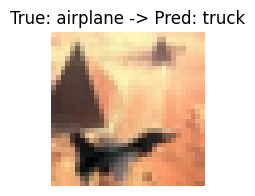

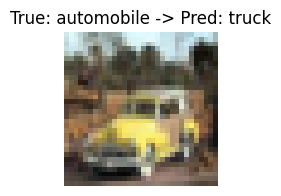

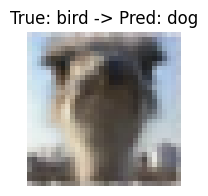

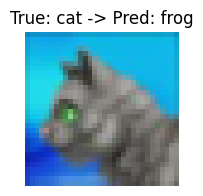

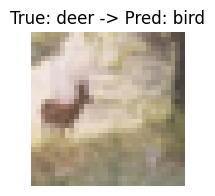

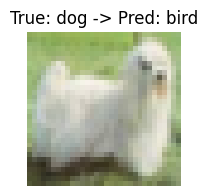

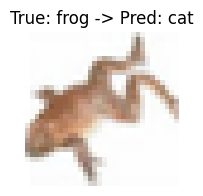

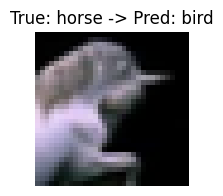

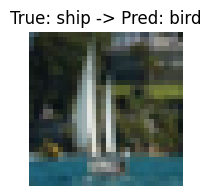

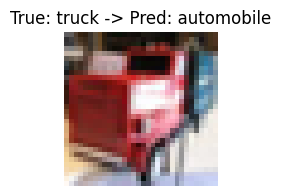

        class  accuracy
0    airplane     0.833
1  automobile     0.924
2        bird     0.746
3         cat     0.655
4        deer     0.829
5         dog     0.637
6        frog     0.928
7       horse     0.885
8        ship     0.924
9       truck     0.930


In [18]:
#4. Tomar un ejemplo mal clasificado de cada clase

misclassified_examples = []
for cls in range(10):
    inds = np.where((y_test == cls) & (y_pred != cls))[0]
    if len(inds) == 0:
        print(f"No hay ejemplos mal clasificados para la clase {class_names[cls]}")
        continue
    idx = np.random.choice(inds)
    misclassified_examples.append((cls, idx, y_pred[idx]))

for true_cls, idx, pred_cls in misclassified_examples:
    plt.figure(figsize=(4,2))
    plt.imshow(x_test[idx])
    plt.axis('off')
    plt.title(f"True: {class_names[true_cls]} -> Pred: {class_names[pred_cls]}")
    plt.show()

# Accuracy por clase
per_class_acc = cm.diagonal() / cm.sum(axis=1)
df_acc = pd.DataFrame({'class': class_names, 'accuracy': per_class_acc})
print(df_acc)

En algunos casos el modelo parece confundir clases debido a su forma, color y/o fondo. 